In [22]:
### Gathering players ####
import os
import json
import numpy as np
winners = []
losers = []
dirs = os.listdir('2022-23Data/') # getting all team folders
matches = np.zeros(1000)
mcount = 0
for direc in dirs: #iterating over team folders
    direcdirs = os.listdir('2022-23Data/' + direc + '/') 
    for direcdirec in direcdirs: #iterating over files
        path = '2022-23Data/' + direc + '/' + direcdirec
        if not direcdirec == '.ipynb_checkpoints': #Who knows what this is... but we don't want it
            
            with open(path,'r') as f:
                data = f.read()
            if len(data)> 33:
                data = json.loads(data[34:-2]) #extracting json file (there's some nonsense at the front)
                data = data['data']
                match= int(data[0]['m'])
                if np.sum(matches == match) > 0:
                    continue
                else:
                    matches[mcount] = match
                    mcount+=1
                for n in range(0,len(data)):
                    
                    if data[n]['f'] == 164 or data[n]['f'] == 165: 
                        if not type(data[n]['pl_opp']) == type(None):
                            winners.append(data[n]['pl'])
                            losers.append(data[n]['pl_opp'])



In [23]:
winners = np.array(winners)
losers = np.array(losers)
players = np.unique(np.append(winners,losers))
indices = np.arange(len(players))

In [24]:
players

array([     0,     36,     38,     48,     54,     56,     74,     93,
          107,    116,    120,    132,    134,    160,    173,    179,
          261,    262,    284,    340,    370,    383,    454,    466,
          471,    703,   3278,   3319,   3324,   3326,   3327,   3348,
         3350,   3351,   3360,   3361,   3413,   3424,   3429,   3436,
         3523,   3551,   3557,   3560,   3577,   3582,   3657,   3662,
         3802,   3928,   4255,   4365,   4908,   5281,   5911,   7847,
         7853,   7855,   7856,   7864,   7868,   7870,   7873,   7879,
         7882,   7885,   7887,   7888,   7892,   7899,   7905,   7906,
         7907,   7910,   7914,   7915,   7918,   7919,   7922,   7928,
         7929,   7932,   7934,   7936,   7938,   7939,   7941,   7944,
         7945,   7957,   7958,   7961,   7964,   7967,   7970,   7974,
         7978,   7988,   7989,   8004,   8005,   8013,   8017,   8032,
         8049,   8066,   8086,   8094,   8116,   8125,   8126,   8135,
      

In [27]:
HeadM = np.zeros((len(players),len(players)))
for n in range(0,len(winners)):
    HeadM[indices[players == winners[n]],indices[players == losers[n]]] += 1
HeadM[:,0]*=0
HeadM[0,:]*=0
HeadM = HeadM - np.diag(HeadM)*np.eye(len(HeadM))

In [29]:
def Equation_System_Old(x):
    Expected_Wins = np.zeros(len(HeadM))
    Actual_Wins = np.zeros(len(HeadM))
    for n in range(0,len(HeadM)):
        for m in range(0,len(HeadM)):
            Expected_Wins[n] += (HeadM[n,m]+HeadM[m,n])/(1+x[n]/x[m])
            Actual_Wins[n] += HeadM[n,m]
    return Expected_Wins-Actual_Wins

13392.0

In [30]:
def Equation_System(x):
    vec = np.ones((len(x),1))
    vec[:,0] = np.abs(x)
    Fraction_Matrix = np.matmul(vec,np.transpose(1/vec))
    Expected_Wins = (HeadM + np.transpose(HeadM))/(1 + Fraction_Matrix)
    if np.random.random() < 0.001:
        print(np.sum(np.square(np.sum(Expected_Wins-HeadM,1))))
    return np.sum(Expected_Wins-HeadM,1)
def Equation_System_Sum(x):
    vec = np.ones((len(x),1))
    vec[:,0] = np.abs(x)
    Fraction_Matrix = np.matmul(vec,np.transpose(1/vec))
    Expected_Wins = (HeadM + np.transpose(HeadM))/(1 + Fraction_Matrix)
    if np.random.random() < 0.001:
        print(np.sum(np.square(np.sum(Expected_Wins-HeadM,1))))
    return np.sum(np.square(np.sum(Expected_Wins-HeadM,1)))

In [31]:
import scipy.optimize
aa = scipy.optimize.fsolve(Equation_System,np.ones((len(HeadM),1)))

60693.00000121817
1365.8690773640856
163.44378804698545
97.02191248758567
66.45536272353004


In [32]:
HA = np.abs(aa)
# Creating Prior:
HA*=1/np.median(HA)
Bins = np.zeros(100) #Bins of size 0.1 up to 10
bsum = 0
for n in range(100):

    Bins[n] = np.sum(HA<n*0.1) - bsum
        
    bsum += Bins[n]

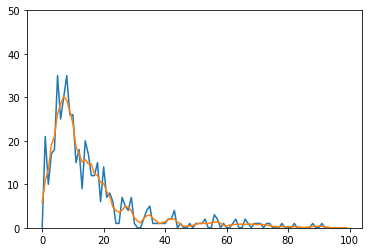

In [33]:
import matplotlib.pyplot as plt
plt.plot(Bins)
plt.ylim([0,50])
BinsSmooth= np.zeros(100)
for m in range(100):
    BinsSmooth[m] = Bins[max([m-2,0])]*0.15 + Bins[max([m-1,0])]*0.2 + 0.3*Bins[m] + 0.2*Bins[min([99,m+1])]+0.15*Bins[min([99,m+2])]
plt.plot(BinsSmooth)
BinsSmooth += 1
def prior(x):
    if  x > 9.95:
        return 0
    elif x < 0:
        return 0
    else:
        return BinsSmooth[round(x*10)]

In [34]:
### Need to sort so that we process in decreasing order of information about the players


NH = np.copy(HA)

counts = np.zeros(len(NH))
for n in range(0,len(HeadM)):
    for m in range(0,len(HeadM)):
        counts[n] += HeadM[n,m] + HeadM[m,n]

counts_arg = np.argsort(counts)
def posterior(x,n,NH):
    probability = 0
    for m in range(0,len(HeadM)):
        probability+= np.log((x/(NH[m] + x)))*(HeadM[n,m])
        probability+= np.log((NH[m]/(NH[m] + x)))*(HeadM[m,n])
    return np.exp(probability)*prior(x)
lc90 = np.zeros(len(HA))
uc90 = np.zeros(len(HA))
for q in range(0,len(NH)):
    index = counts_arg[q]
    post_sum = 0
    for step in range(1,100):
        post_sum += posterior(step*0.1,index,NH)
    
    
    curr = 0.1
    integ = 0
    
    
    
    while integ < 0.1:
        integ += posterior(curr,index,NH)/post_sum
        curr+=0.1
    lc90[index] = curr
    while integ < 0.5:
        integ += posterior(curr,index,NH)/post_sum
        curr+=0.1
    median_val = curr
    integ = 0
    curr = 10
    while integ < 0.1:
        integ += posterior(curr,index,NH)/post_sum
        curr-=0.1
    NH[index] = median_val
    uc90[index] = curr
    print(q,median_val)
            
        

0 1.4000000000000001
1 1.4000000000000001
2 1.4000000000000001
3 1.0999999999999999
4 0.7999999999999999
5 2.0000000000000004
6 1.7000000000000004
7 1.7000000000000004
8 0.7
9 1.7000000000000004
10 1.8000000000000005
11 0.9999999999999999
12 0.8999999999999999
13 0.7999999999999999
14 0.9999999999999999
15 0.8999999999999999
16 2.3000000000000007
17 2.700000000000001
18 1.5000000000000002
19 1.0999999999999999
20 1.2
21 2.400000000000001
22 0.7
23 1.2
24 0.6
25 2.1000000000000005
26 0.7
27 1.0999999999999999
28 0.9999999999999999
29 1.7000000000000004
30 1.0999999999999999
31 1.8000000000000005
32 4.000000000000002
33 1.5000000000000002
34 0.6
35 1.0999999999999999
36 0.8999999999999999
37 0.8999999999999999
38 5.399999999999997
39 1.0999999999999999
40 0.7999999999999999
41 0.7999999999999999
42 0.7999999999999999
43 1.8000000000000005
44 1.6000000000000003
45 0.7
46 4.000000000000002
47 3.0000000000000013
48 0.7999999999999999
49 4.100000000000001
50 1.5000000000000002
51 2.600000000

In [35]:
median = np.median(NH)
def final(x):
    return (x/(x+median))*100
lc90f = final(lc90)
NHf = final(NH)
uc90f = final(uc90)

In [36]:
import csv
with open('HeadingAttr.csv','w') as f:
    writer = csv.writer(f)
    for n in range(0,len(NHf)):
        writer.writerow([players[n],lc90f[n],NHf[n],uc90f[n]])